# Causal Data Science Week 2 Tutorial

In this toturial, you will learn:
- how to use the package networkX to design causal graphs of your own
- how to check step-by-step if a d-separation holds
- how to test independence and correlation between variables

In [1]:
# WARNING:
# The installation takes a few minutes.
# Only run during the first time running this notebook and if you don't have these packages installed.
# Run in terminal command line instead if it does not work.

# !pip install hyppo
# !pip install pingouin
# !pip install conditional_independence

import pandas as pd
from pathlib import Path
from os import path
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib import pyplot 

In [2]:
# Import packages
from itertools import permutations

import conditional_independence
import hyppo
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pingouin as pg

np.random.seed(0)

## Intro to NetworkX

NetworkX ([documentation](https://networkx.org/documentation/stable/reference/introduction.html)) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks. With NetworkX you can load and store networks in standard and nonstandard data formats, generate many types of random and classic networks, analyze network structure, build network models, design new network algorithms, draw networks, and much more. Our main use case of NetworkX is to design the causal graphs that we assumed and load them into the DoWhy package.

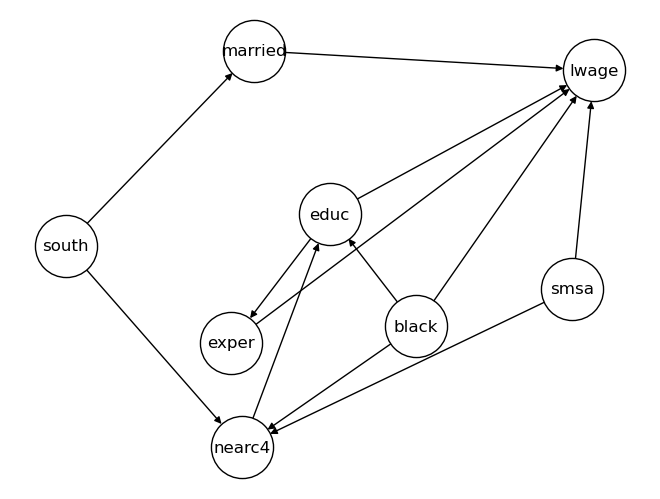

In [3]:
# Add a node to the graph, labelled '1'.
G = nx.DiGraph()

G.add_nodes_from(["lwage", "educ", "exper", "black", "south", "married", "smsa", "nearc4"])

G.add_edges_from([
    ("educ", "lwage"), ("exper", "lwage"), 
    ("black", "lwage"), ("south", "married"), ("married", "lwage"),
    ("nearc4", "educ"),
    ("black", "educ"), ("south", "nearc4"),
    ("married", "lwage"), 
    ("black", "nearc4"), ("smsa", "nearc4"), ("smsa", "lwage"), ("educ", "exper")
])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear)
# and save it to a .gml format (for using DoWhy later)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos= pos, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [4]:
# Check the current number of nodes and edges in the graph.
print("Current number of nodes in the graph is ", G.number_of_nodes())
print("Current number of edges in the graph is ", G.number_of_edges())

Current number of nodes in the graph is  8
Current number of edges in the graph is  12


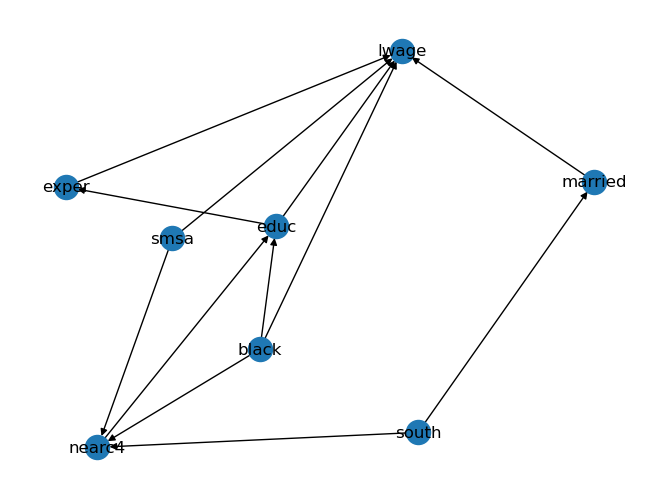

In [5]:
# Export and import the graph in GML format, used by DoWhy, for later use
nx.write_gml(G, "G.gml")
H = nx.read_gml("G.gml")
nx.draw(H, with_labels=True)

In [6]:
# Generate GML format as string for input into DoWhy
G_gml = ''.join(nx.generate_gml(G))
print(G_gml)

graph [  directed 1  node [    id 0    label "lwage"  ]  node [    id 1    label "educ"  ]  node [    id 2    label "exper"  ]  node [    id 3    label "black"  ]  node [    id 4    label "south"  ]  node [    id 5    label "married"  ]  node [    id 6    label "smsa"  ]  node [    id 7    label "nearc4"  ]  edge [    source 1    target 0  ]  edge [    source 1    target 2  ]  edge [    source 2    target 0  ]  edge [    source 3    target 0  ]  edge [    source 3    target 1  ]  edge [    source 3    target 7  ]  edge [    source 4    target 5  ]  edge [    source 4    target 7  ]  edge [    source 5    target 0  ]  edge [    source 6    target 7  ]  edge [    source 6    target 0  ]  edge [    source 7    target 1  ]]


## D-separation
We have seen d-separation in the lectures. Let's see how we can use NetworkX to find a conditioning set that d-separates two nodes in a graph. Let's start with the relevant definitions for the case of single nodes:

> **D-separation**: The nodes $X$ and $Y$ are d-separated by $Z \subseteq V\setminus\{X,Y\}$ if all paths between them are blocked by $Z$.

> **Blocking**: A path between nodes $X$ and $Y$ is blocked by $Z \subseteq V\setminus\{X,Y\}$ if at least one of the following conditions holds:
> - There is a non-collider on the path that is in $Z$
> - There is a collider node $k$ on the path, such that $k \notin Z$ and $Desc(k) \cap A = \emptyset$

To test our algorithms, consider the DAG below and let's say we wish to decide whether conditioning on some set of nodes $Z$ d-separates the nodes 1 and 6 (marked as red).

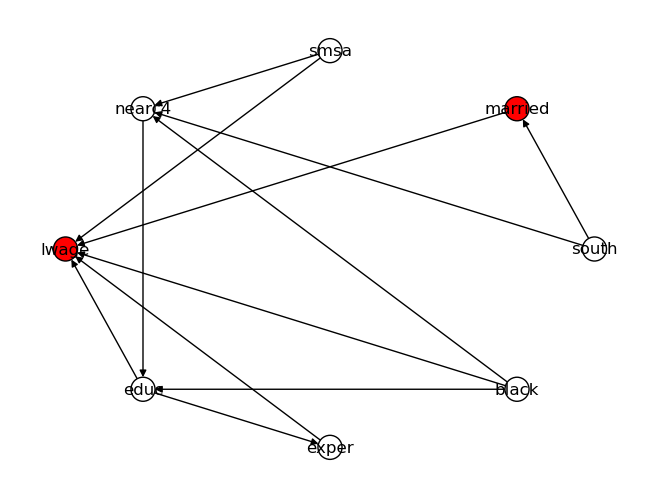

In [7]:
#needs re checking
# Create a graph
# G = nx.DiGraph()
# G.add_nodes_from([1, 2, 3, 4, 5, 6])
# G.add_edges_from([(1, 3), (1, 5), (2, 1), (2, 6), (3, 6), (4, 3), (4, 6), (6, 5)])

# x = 1
# y = 6
x = 'educ'
y = 'lwage'
nx.draw_shell(G, with_labels=True, node_color=['r', 'w', 'w', 'w', 'w', 'r', 'w', 'w'], edgecolors='black')

First, we need  a function to find all paths between the two nodes. This is already provided by NetworkX.

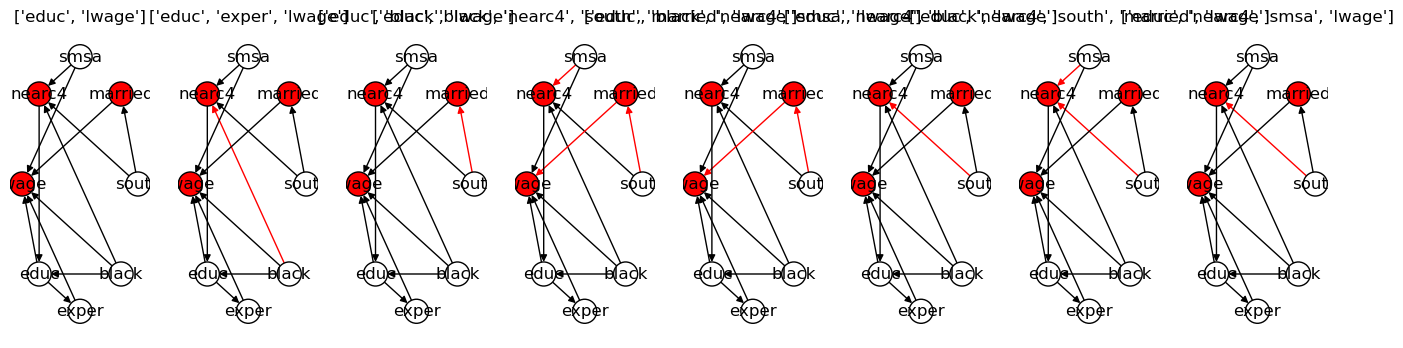

In [8]:
# Get all paths (as defined in the class, these are not just the directed paths)
all_paths = list(nx.all_simple_paths(G.to_undirected(), source=x, target=y))

# Visualize paths
fig, axs = plt.subplots(nrows=1, ncols=len(all_paths), figsize=(17, 4))
for path, ax in zip(all_paths, axs):
    edges_on_path = [(source, target) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if edge in edges_on_path else 'black' for edge in G.to_undirected().edges()]
    nx.draw_shell(G, with_labels=True, node_color=['r', 'w', 'w', 'w', 'w', 'r', 'w', 'r'], edgecolors='black', ax=ax, edge_color=edge_color)
    ax.set_title(path)

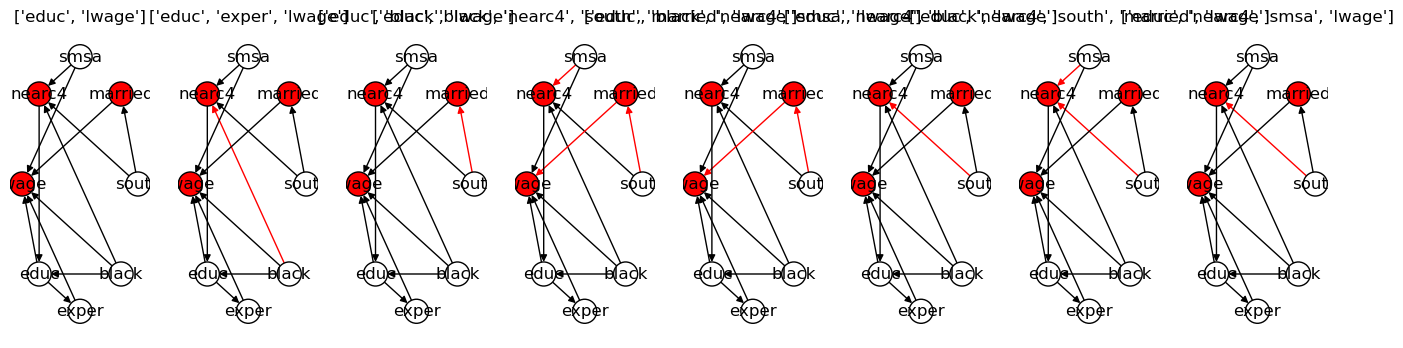

In [8]:
# Get all paths (as defined in the class, these are not just the directed paths)
all_paths = list(nx.all_simple_paths(G.to_undirected(), source=x, target=y))

# Visualize paths
fig, axs = plt.subplots(nrows=1, ncols=len(all_paths), figsize=(17, 4))
for path, ax in zip(all_paths, axs):
    edges_on_path = [(source, target) for source, target in zip(path[:-1], path[1:])]
    edge_color = ['r' if edge in edges_on_path else 'black' for edge in G.to_undirected().edges()]
    nx.draw_shell(G, with_labels=True, node_color=['r', 'w', 'w', 'w', 'w', 'r', 'w', 'r'], edgecolors='black', ax=ax, edge_color=edge_color)
    ax.set_title(path)

The definition of blocking paths is concerned with colliders and non-colliders. Thus, we need a function to find colliders and non-colliders on a path. To do so, consider the definition of colliders:
> A collider $k$ on a path $\pi = (x,...,y)$ is a non-endpoint node ($k \neq x,y$) such that the path $\pi$ contans $\to k \leftarrow$. Non-endpoint nodes without this patthern are non-colliders.

Let's implement an algorithm to find all colliders and non-colliders step-by-step

In [13]:
# Check if a node is an end-point on the path

def is_endpoint(path, node):
    return node in [path[0], path[-1]]

print('Node {} is an endpoint on path {}: {}'.format('educ', all_paths[1], is_endpoint(all_paths[1], 'educ')))
print('Node {} is an endpoint on path {}: {}'.format('lwage', all_paths[1], is_endpoint(all_paths[1], 'lwage')))

Node educ is an endpoint on path ['educ', 'exper', 'lwage']: True
Node lwage is an endpoint on path ['educ', 'exper', 'lwage']: True


In [14]:
### recheck 
# Get previous and successor nodes on path
def get_prev_and_succ(path, node):
    ind = path.index(node)
    prev, succ = path[ind-1], path[ind+1]
    return prev, succ

print('Previous and successor nodes of node {} on path {} are nodes {} and {} respectively'.format(
    'lwage', all_paths[1], *get_prev_and_succ(all_paths[1], 'lwage')))

IndexError: list index out of range

In [15]:
# Check whether a node is a collider on a path
def is_collider(G, path, node):
    if node not in path:  # Check if node is on path
        return False
    elif is_endpoint(path, node):  # Check if non-endpoint
        return False
    else: # Check if both edges point towards the node
        prev, succ = get_prev_and_succ(path, node)
        return (prev, node) in G.edges() and (succ, node) in G.edges()

print('{} is a collider on path {}: {}'.format(1, all_paths[1], is_collider(G, all_paths[1], 1)))
print('{} is a collider on path {}: {}'.format(4, all_paths[1], is_collider(G, all_paths[1], 4)))
print('{} is a collider on path {}: {}'.format(3, all_paths[1], is_collider(G, all_paths[1], 3)))

1 is a collider on path [1, 3, 4, 6]: False
4 is a collider on path [1, 3, 4, 6]: False
3 is a collider on path [1, 3, 4, 6]: True


In [21]:
# Get all colliders on a path
def get_colliders(G, path):
    colliders = set([node for node in path if is_collider(G, path, node)])
    return colliders


print('Colliders on path {}: {}'.format(all_paths[0], get_colliders(G, all_paths[0])))
print('Colliders on path {}: {}'.format(all_paths[1], get_colliders(G, all_paths[1])))
print('Colliders on path {}: {}'.format(all_paths[2], get_colliders(G, all_paths[2])))

Colliders on path [1, 3, 6]: set()
Colliders on path [1, 3, 4, 6]: {3}
Colliders on path [1, 5, 6]: {5}


In [22]:
# Check whether a node is a non-collider on a path
def is_non_collider(G, path, node):
    if node not in path:  # Check if node is on path
        return False
    elif is_endpoint(path, node):  # Check if non-endpoint
        return False
    else:
        return not is_collider(G, path, node)


print('{} is a non-collider on path {}: {}'.format(1, all_paths[1], is_non_collider(G, all_paths[1], 1)))
print('{} is a non-collider on path {}: {}'.format(4, all_paths[1], is_non_collider(G, all_paths[1], 4)))
print('{} is a non-collider on path {}: {}'.format(3, all_paths[1], is_non_collider(G, all_paths[1], 3)))

1 is a non-collider on path [1, 3, 4, 6]: False
4 is a non-collider on path [1, 3, 4, 6]: True
3 is a non-collider on path [1, 3, 4, 6]: False


In [23]:
# Get all non-colliders on a path
def get_non_colliders(G, path):
    non_colliders = set([node for node in path if is_non_collider(G, path, node)])
    return non_colliders


print('Non-olliders on path {}: {}'.format(all_paths[0], get_non_colliders(G, all_paths[0])))
print('Non-Colliders on path {}: {}'.format(all_paths[1], get_non_colliders(G, all_paths[1])))
print('Non-Colliders on path {}: {}'.format(all_paths[2], get_non_colliders(G, all_paths[2])))

Non-olliders on path [1, 3, 6]: {3}
Non-Colliders on path [1, 3, 4, 6]: {4}
Non-Colliders on path [1, 5, 6]: set()


In [24]:
# Get all descendants of a node
def get_descendants(G, node):
    return nx.descendants(G, node).union([node])


print('Descendants of node {} are {}'.format(1, get_descendants(G, 1)))
print('Descendants of node {} are {}'.format(3, get_descendants(G, 3)))

Descendants of node 1 are {1, 3, 5, 6}
Descendants of node 3 are {3, 5, 6}


With all these functions, we can finally test whether a set of nodes block a specific path. As a reminder, we check if at least one of the following conditions hold:
- There is a non-collider on the path that is in $Z$
- There is a collider node $k$ on the path, such that $k \notin Z$ and $Desc(k) \cap A = \emptyset$

Now, checking whether two nodes are d-separated by a set of nodes in a graph is easy. We just get all paths between them and check if they are all blocked.

Now that you understand how d-separation works, **you should use the much more efficient and tested function provided by NetworkX**

## Independence tests

In the lecture, we saw that if the Global Markov Property holds, then for any Bayesian Network $(G,p)$ it holds that
$$
A \perp_d B | C \Rightarrow X_A \perp \!\!\! \perp X_B | X_C
$$

Let's see if this indeed holds in practice, with some simple graphs and artificially generated data according to them. We will use various statistical **independence tests** to check whether two variables are (conditionally) independent and if this is in line with d-separation in the graph. The null-hypothesis is always that the two variables are independent, $X\!\perp\!\!\!\perp Y$, while the alternative hypothesis is that they are dependent, $X \not \!\perp\!\!\!\perp Y$. In general, we can only reject the null-hypothesis given a significant (very low) p-value, however in causality we often also accept hypotheses. The p-value describes the probability of obtaining the samples we have if we assume that the null hypothesis is true. If this probability is lower than some threshold $\alpha$, usually set to 0.05, then it is very unlikely that the null hypothesis is true, and instead provides evidence for the alternative hypothesis. For an introduction on p-values you can watch [this video](https://www.youtube.com/watch?v=KS6KEWaoOOE), and for a more in-depth description of independence tests check [this video](https://www.youtube.com/watch?v=zOvUQWOzTlc).

We can do correlation and independence tests on data with conditional distributions using the pingouin package. Partial correlation measures the degree of association between x and y, after removing the effect of one or more controlling variables (covar, or 𝑍). For more implementation details see: https://pingouin-stats.org/generated/pingouin.partial_corr.html#pingouin.partial_corr

#### Confounding
We will demonstrate marginally dependent but conditionally independent data with three variables generated by the following SCM, where $Z$ is a confounder:
$$
\begin{aligned}
Z &\leftarrow \epsilon_Z \\
X &\leftarrow Z + \epsilon_X \\
Y &\leftarrow Z + \epsilon_Y \\
\epsilon_X, \epsilon_Y,\epsilon_Z &\sim \mathcal N(0,1)
\end{aligned}
$$

The SCM above can be represent by the following graph, where I denote both the random variables and their corresponding nodes in the graph as $X, Y$ and $Z$.
:
$$
X \leftarrow Z \to Y
$$

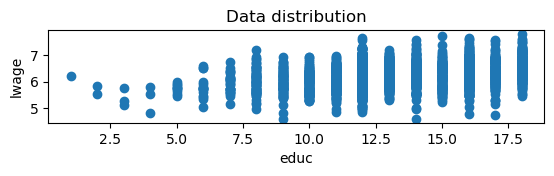

In [16]:
# done
close_college_path = "C:/Users/antar/Downloads/Causal Data Science/causal_data/data/close_college.dta"
#assert path.exists(close_college_path)
close_college = pd.read_stata(close_college_path)

# Visualize
plt.scatter(close_college['educ'], close_college['lwage'])
plt.gca().set_aspect('equal')
plt.xlabel('educ')
plt.ylabel('lwage')
plt.title('Data distribution')
plt.show()

The graph above shows that $X$ and $Y$ are d-connected if we do not condition on anything; $X \not\perp_d Y$. This means that $X$ and $Y$ should be marginally dependent; $X \not \!\perp\!\!\!\perp Y$. Let's check if this is indeed true given the data, by testing their marginal correlation using [Pearson's correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) test.

In [18]:
pg.partial_corr(data=close_college, x='educ', y='lwage', covar=[], method='pearson')

,n,r,CI95%,p-val
pearson,3010,0.314224,"[0.28, 0.35]",5.771739e-70


The test returns a significant (very small) p-value, thus we reject the null hypothesis of $X$ and $Y$ being independent and establish that they are dependent, which is exactly what we expected.

According to the graph above, $X$ and $Y$ are d-separated by $Z$; $X \perp_d Y | Z$, which should imply that $X$ and $Y$ are conditionally independent given $Z$; $X \perp\!\!\!\perp Y | Z$. Let's check if this also holds true based on the data.

In [19]:
pg.partial_corr(data=close_college, x='educ', y='lwage', covar=['nearc4'], method='pearson')

,n,r,CI95%,p-val
pearson,3010,0.297706,"[0.26, 0.33]",1.228262e-62


Now the test returns an insignificant (large) p-value, thus we cannot reject the null hypothesis of $X \perp\!\!\!\perp Y | Z$, which is, again, exactly what we expected.

We can further verify if all possible marginal/conditional (isize)dependencies in the data match our expectations based on the graph. Notice that symmetry in the tests.

In [20]:
def test_all(df, vars=['educ', 'lwage', 'nearc4']):
    # Marginal
    for var1, var2 in permutations(vars, 2):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[], method='pearson')['p-val'].item()
        print('{} and {}: p-value is {}'.format(var1, var2, p_val))

    # Conditional
    for var1, var2, cond in permutations(vars, 3):
        p_val = pg.partial_corr(data=df, x=var1, y=var2, covar=[cond], method='pearson')['p-val'].item()
        print('{} and {} given {}: p-value is {}'.format(var1, var2, cond, p_val))

In [22]:
test_all(close_college)

educ and lwage: p-value is 5.771738967940163e-70
educ and nearc4: p-value is 1.837526956641275e-15
lwage and educ: p-value is 5.7717389679395045e-70
lwage and nearc4: p-value is 1.654924447472093e-19
nearc4 and educ: p-value is 1.8375269566413086e-15
nearc4 and lwage: p-value is 1.654924447472093e-19
educ and lwage given nearc4: p-value is 1.2282615129151807e-62
educ and nearc4 given lwage: p-value is 5.0923604571401563e-08
lwage and educ given nearc4: p-value is 1.2282615129149354e-62
lwage and nearc4 given educ: p-value is 4.140739437434652e-12
nearc4 and educ given lwage: p-value is 5.092360457140064e-08
nearc4 and lwage given educ: p-value is 4.140739437434981e-12


## recheck
As expected, we get significant p-values for all tests, implying dependence, except when we condition on the confounder $Z$.

#### Chain
Let's also check a chain structure $X \to Y \to Z$ given the following SCM:
$$
\begin{aligned}
X &\leftarrow \epsilon_X \\
Y &\leftarrow X + \epsilon_Y \\
Z &\leftarrow Y + \epsilon_Z \\
\epsilon_X, \epsilon_Y, \epsilon_Z &\sim \mathcal N(0,1)
\end{aligned}
$$

In [33]:
# Generate data
x = np.random.normal(size=size)
y = x + np.random.normal(size=size)
z = y + np.random.normal(size=size)
df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})

According to the graph, only $X$ and $Z$ can be d-separated, by conditioning on $Y$. Let's see if the independence tests agree with this.

In [34]:
test_all(df)

X and Y: p-value is 2.8314650019455394e-153
X and Z: p-value is 3.6017664629813863e-97
Y and X: p-value is 2.831465001946184e-153
Y and Z: p-value is 8.683320032591796e-241
Z and X: p-value is 3.6017664629813863e-97
Z and Y: p-value is 8.683320032588835e-241
X and Y given Z: p-value is 2.3211696297809483e-58
X and Z given Y: p-value is 0.18501145439536948
Y and X given Z: p-value is 2.3211696297826696e-58
Y and Z given X: p-value is 6.914606911139447e-146
Z and X given Y: p-value is 0.18501145439537417
Z and Y given X: p-value is 6.914606911135904e-146


As we can see, the p-values are always significant except when testing $X \perp\!\!\!\perp Z | Y$ and $Z \perp\!\!\!\perp X | Y$.

#### Collider
We should see something different when testing a collider structure; $X \to Z \leftarrow Y$, given the following SCM:
$$
\begin{aligned}
X &\leftarrow \epsilon_X \\
Y &\leftarrow \epsilon_Y \\
Z &\leftarrow X + Y + \epsilon_Z \\
\epsilon_X, \epsilon_Y,\epsilon_Z &\sim \mathcal N(0,1)
\end{aligned}
$$

In [35]:
# Generate data
x = np.random.normal(size=size)
y = np.random.normal(size=size)
z = x + y + np.random.normal(size=size)
df = pd.DataFrame({'X': x, 'Y': y, 'Z': z})

Now we expect to see insignificant p-values only for the test of the marginal independence $X \perp\!\!\!\perp Y$, as the path between them is blocked if we **do not** condition on the collider $Z$.

In [36]:
test_all(df)

X and Y: p-value is 0.4698260589224599
X and Z: p-value is 1.052007506686635e-96
Y and X: p-value is 0.4698260589224609
Y and Z: p-value is 1.1854083139092133e-90
Z and X: p-value is 1.052007506686635e-96
Z and Y: p-value is 1.1854083139092133e-90
X and Y given Z: p-value is 1.1489592534231739e-61
X and Z given Y: p-value is 3.17500301398521e-156
Y and X given Z: p-value is 1.148959253423305e-61
Y and Z given X: p-value is 3.4839343283472705e-150
Z and X given Y: p-value is 3.175003013980513e-156
Z and Y given X: p-value is 3.483934328344892e-150


#### Descendants

The second condition of blocking establishes not only that there has to be a collider $k \notin Z$, but also that $Desc(k) \cap Z = \emptyset$. Let's see in practice why this additional condition is important using the previous collider structure with an extra variable $W$ caused by the collider $Z$. Now our SCM is defined as
$$
\begin{aligned}
X &\leftarrow \epsilon_X \\
Y &\leftarrow \epsilon_Y \\
Z &\leftarrow X + Y + \epsilon_Z \\
W &\leftarrow Z + \epsilon_W \\
\epsilon_X, \epsilon_Y, \epsilon_Z, \epsilon_W &\sim \mathcal N(0,1)
\end{aligned}
$$

In [37]:
# Generate data
x = np.random.normal(size=size)
y = np.random.normal(size=size)
z = x + y + np.random.normal(size=size)
w = z + np.random.normal(size=size)
df = pd.DataFrame({'X': x, 'Y': y, 'Z': z, 'W': w})

In [38]:
print('X and Y: {}'.format(pg.partial_corr(data=df, x='X', y='Y', covar=[], method='pearson')['p-val'].item()))
print('X and Y given W: {}'.format(pg.partial_corr(data=df, x='X', y='Y', covar=['W'], method='pearson')['p-val'].item()))

X and Y: 0.47218083473650563
X and Y given W: 8.503989445727031e-25


As we can see, eventhough $W$ is not a collider on any paths between the marginally independent variables $X$ and $Y$ (in particular, it is not even on any paths between them), it still makes them conditionally dependent.

#### Uncorrelated but dependent data

Unfortunately, the outcome of statistical tests highly depend on the data generation process, and can yield false results. For example, $X$ and $Y$ in the following SCM are dependent ($X \to Y$), but testing with Pearson's correlation will show not be able to reject the null hypothesis.

\begin{aligned}
X &\leftarrow \epsilon_X \\
Y &\leftarrow \cos(x) + \epsilon_Y \\
\epsilon_X &\sim \mathcal N(0,2)\\
\epsilon_Y &\sim \mathcal N(0, 0.5)
\end{aligned}
$$

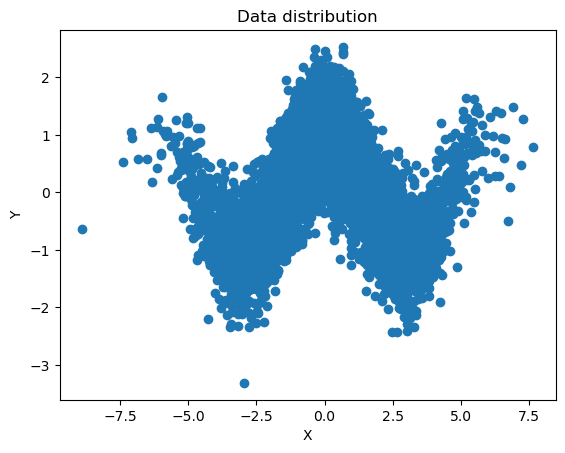

In [39]:
# Generate data
size = 10000
x = np.random.normal(0, 2, size=size)
y = np.cos(x) + np.random.normal(0, 0.5, size=size)
df = pd.DataFrame({'X': x, 'Y': y})

# Visualize
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data distribution')
plt.show()

In [40]:
# Marginal Pearson's correlation test (don't need Pandas df)
pg.corr(x=x, y=y, method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,10000,0.004892,"[-0.01, 0.02]",0.624758,0.014,0.077827


From the scatter plot above, we can see that two variables are uncorrelated because as one variable increases the other one does not increase or decrease. This is also confirmed by the insignificant p-value from the statistical test above. However, from the way we generate the data samples, we know that $y$ is a function of $x$ and they are dependent.  In general, when two variables are independent, the correlation coefficient is zero. However, the inverse is not true.

Instead of Pearson's correlation, we can try to use Hilbert Schmidt Independence Criterion (Hsic) to test the dependence of the data above. Hsic is a kernel based independence test and is a way to measure multivariate nonlinear associations given a specified kernel [1]. Hsic is available from the `hyppo` package imported in the first cell.

[1] Arthur Gretton, Kenji Fukumizu, Choon Teo, Le Song, Bernhard Schölkopf, and Alex Smola. A Kernel Statistical Test of Independence. Advances in Neural Information Processing Systems, 2007.
https://proceedings.neurips.cc/paper/2007/file/d5cfead94f5350c12c322b5b664544c1-Paper.pdf

In [ ]:
hyppo.independence.Hsic().test(x, y)

The significant p-value tells us that these two variables are not independent, so the test confirms what we already know.

If we would like to test for conditional independence with Hsic, then we need to use the `conditional_independence` package. This package is **not very well documented** yet. However, there are a few well documented implementations in R and Matlab. Those who are comfortable with R and Matlab can check here: https://github.com/garydoranjr/kcipt/ and 
https://github.com/ericstrobl/RCIT.

We can generate similar data as above, but now including a mediator, as $X \to Y \to Z$, with the following SCM:
$$
\begin{aligned}
X &\leftarrow \epsilon_X \\
Y &\leftarrow 2x \\
Z &\leftarrow \cos(x) + \epsilon_Z\\
\epsilon_X &\sim \mathcal N(0,2)\\
\epsilon_Z &\sim \mathcal N(0, 0.5)
\end{aligned}
$$

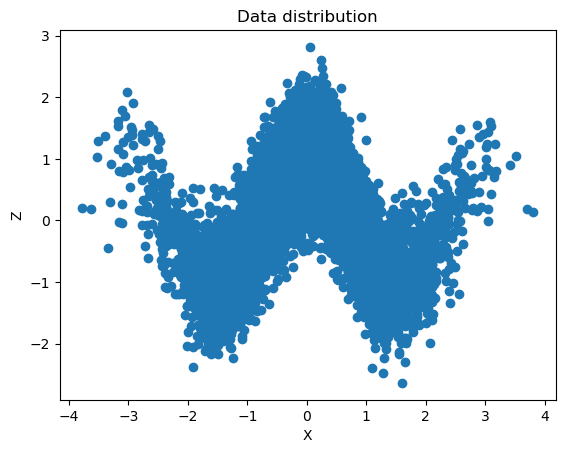

In [37]:
# Generate data
x = np.random.normal(size=size)
y = 2*x
z = np.cos(y) + np.random.normal(0, 0.5, size=size)
df = pd.DataFrame({'X': x, 'Y': y})

# Visualize
plt.scatter(x, z)
plt.xlabel('X')
plt.ylabel('Z')
plt.title('Data distribution')
plt.show()

According to the graph, $X$ and $Z$ are only d-separated by $Y$; $X \not\perp_d Z$ but $X \perp_d Z | Y$. Thus, we expect to reject the null hypothesis of marginal independence $X \perp\!\!\!\perp Z$, but unable to reject the null hypothesis of conditional independence $X \perp\!\!\!\perp Z | Y$.

In [38]:
conditional_independence.hsic_test(np.stack((x,y,z), axis=1), i=0, j=2, cond_set=[])

{'statistic': 0.02865794367906598,
 'p_value': 0.0,
 'reject': True,
 'mean_approx': 2.790332979181241e-05,
 'var_approx': 2.334188905283573e-10}

In [39]:
conditional_independence.hsic_test(np.stack((x,y,z), axis=1), i=0, j=2, cond_set=[1]) # might give nan as p-value

{'statistic': 7.376475222121517e-24,
 'p_value': 1.0,
 'reject': False,
 'mean_approx': 1.1102230246251566e-20,
 'var_approx': 4.445809846932813e-42}

## Post-interventional distributions

The lectures have also introduced interventions and the $do()$ operator. In the lectures and the exercises we have seen that the post-interventional distribution is usually not the same as the observational one. Using the example given in the lectures, let's simulate observational and interventional data generation and check if this is indeed the case. The example states that there is a certain probability of fire, the fire causes smoke to appear, and the smoke turns on the alarm system, with the following probabilities:
$$
\begin{aligned}
P(F=1)     &= 0.01 \\
P(S=1|F=0) &= 0.2 \\ 
P(S=1|F=1) &= 0.9 \\
P(A=1|S=0) &= 0.8 \\
P(A=1|S=1) &= 0.1 \\
\end{aligned}
$$
The mechanism above can be represented as the causal graph $F \to S \to A$. What does the causal graph imply on the difference between the observational and the post-interventional distributions? For starters, let's see what happens if we intervene on the alarm, by "forcing" it to turn off or on. This implies the manipulated graph; $F \to S \not\to A$.

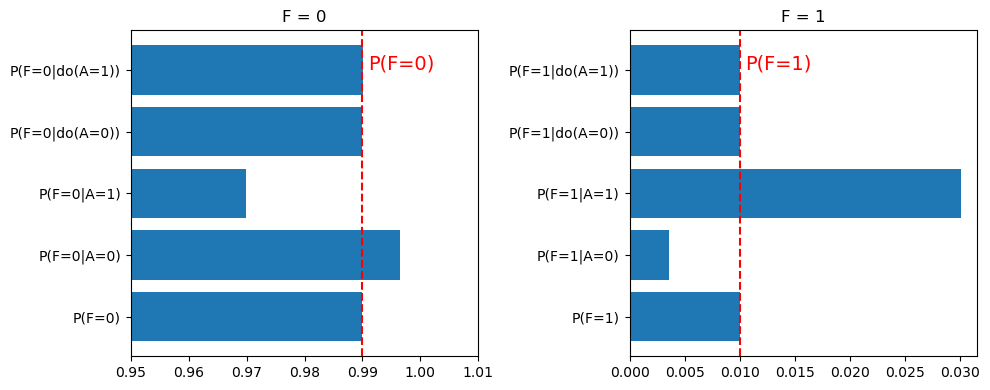

In [40]:
size = 1000000
stats = {
    'P(F=0)': 0.99,
    'P(F=1)': 0.01
}

# observational
fire = np.random.binomial(1, 0.01, size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(F=0|A=0)'] = ((fire == 0) & (alarm == 0)).sum() / (alarm == 0).sum()
stats['P(F=1|A=0)'] = ((fire == 1) & (alarm == 0)).sum() / (alarm == 0).sum()
stats['P(F=0|A=1)'] = ((fire == 0) & (alarm == 1)).sum() / (alarm == 1).sum()
stats['P(F=1|A=1)'] = ((fire == 1) & (alarm == 1)).sum() / (alarm == 1).sum()

# interventional do(A=0)
fire = np.random.binomial(1, 0.01, size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = np.zeros(size)
stats['P(F=0|do(A=0))'] = (fire == 0).sum() / size
stats['P(F=1|do(A=0))'] = (fire == 1).sum() / size

# interventional do(A=1)
fire = np.random.binomial(1, 0.01, size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = np.ones(size)
stats['P(F=0|do(A=1))'] = (fire == 0).sum() / size
stats['P(F=1|do(A=1))'] = (fire == 1).sum() / size

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
# F = 0
ax0.barh(list(stats.keys())[::2], list(stats.values())[::2])
ax0.axvline(x=stats['P(F=0)'], ymin=0, ymax=1, color='r', linestyle='--')
ax0.text(stats['P(F=0)'] + 0.001, 4, 'P(F=0)', color='r', size=14)
ax0.set_xlim(0.95,1.01)
ax0.set_title('F = 0')
# F = 1
ax1.barh(list(stats.keys())[1::2], list(stats.values())[1::2])
ax1.axvline(x=stats['P(F=1)'], ymin=0, ymax=1, color='r', linestyle='--')
ax1.text(stats['P(F=1)'] + 0.0005, 4, 'P(F=1)', color='r', size=14)
ax1.set_title('F = 1')

fig.tight_layout()
plt.show()

The data confirms that the post-interventional probabilities are different than observational ones; $P(F|A) \neq P(F|do(A))$, and agree with our intuition, that forcing the alarm to be off or on does not change the probability of fire; $P(F) = P(F|do(A))$ . What happens if we instead intervene on fire? Then the causal graph remains the same and we expect post-interventional distributions to match observational ones.

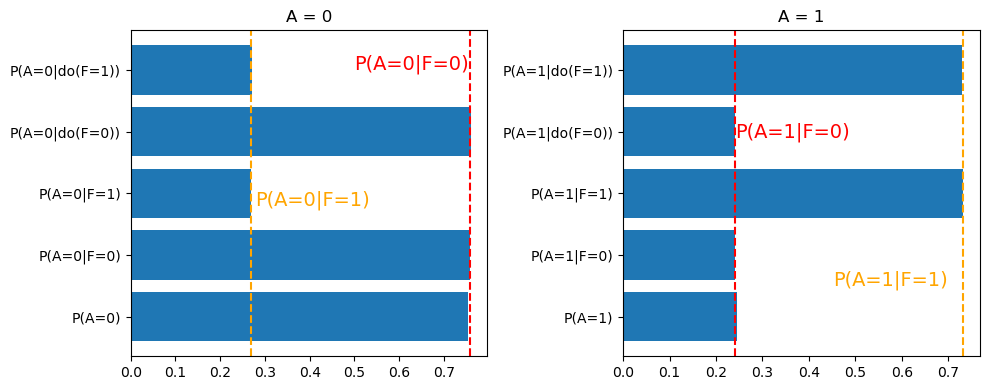

In [41]:
size = 1000000
stats = {}

# observational
fire = np.random.binomial(1, 0.01, size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0)'] = (size - alarm.sum()) / size
stats['P(A=1)'] = alarm.sum() / size
stats['P(A=0|F=0)'] = ((fire == 0) & (alarm == 0)).sum() / (fire == 0).sum()
stats['P(A=1|F=0)'] = ((fire == 0) & (alarm == 1)).sum() / (fire == 0).sum()
stats['P(A=0|F=1)'] = ((fire == 1) & (alarm == 0)).sum() / (fire == 1).sum()
stats['P(A=1|F=1)'] = ((fire == 1) & (alarm == 1)).sum() / (fire == 1).sum()

# interventional do(F=0)
fire = np.zeros(size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0|do(F=0))'] = (alarm == 0).sum() / size
stats['P(A=1|do(F=0))'] = (alarm == 1).sum() / size

# interventional do(A=1)
fire = np.ones(size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0|do(F=1))'] = (alarm == 0).sum() / size
stats['P(A=1|do(F=1))'] = (alarm == 1).sum() / size

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
# A = 0
ax0.barh(list(stats.keys())[::2], list(stats.values())[::2])
ax0.axvline(x=stats['P(A=0|F=0)'], ymin=0, ymax=1, color='r', linestyle='--')
ax0.text(stats['P(A=0|F=0)']-0.26, 4, 'P(A=0|F=0)', color='r', size=14)
ax0.axvline(x=stats['P(A=0|F=1)'], ymin=0, ymax=1, color='orange', linestyle='--')
ax0.text(stats['P(A=0|F=1)']+0.01, 1.8, 'P(A=0|F=1)', color='orange', size=14)
ax0.set_title('A = 0')
# A = 1
ax1.barh(list(stats.keys())[1::2], list(stats.values())[1::2])
ax1.axvline(x=stats['P(A=1|F=0)'], ymin=0, ymax=1, color='r', linestyle='--')
ax1.text(stats['P(A=1|F=0)']+0.001, 2.9, 'P(A=1|F=0)', color='r', size=14)
ax1.axvline(x=stats['P(A=1|F=1)'], ymin=0, ymax=1, color='orange', linestyle='--')
ax1.text(stats['P(A=1|F=1)']-0.28, 0.5, 'P(A=1|F=1)', color='orange', size=14)
ax1.set_title('A = 1')

fig.tight_layout()
plt.show()

As the plots above show, the observational and post-interventional distributions indeed match.

Finally, let's what happens if we measure $P(A|F, do(S))$, with smoke being the intervention target, which induces the graph; $F \not\to S \to A$.

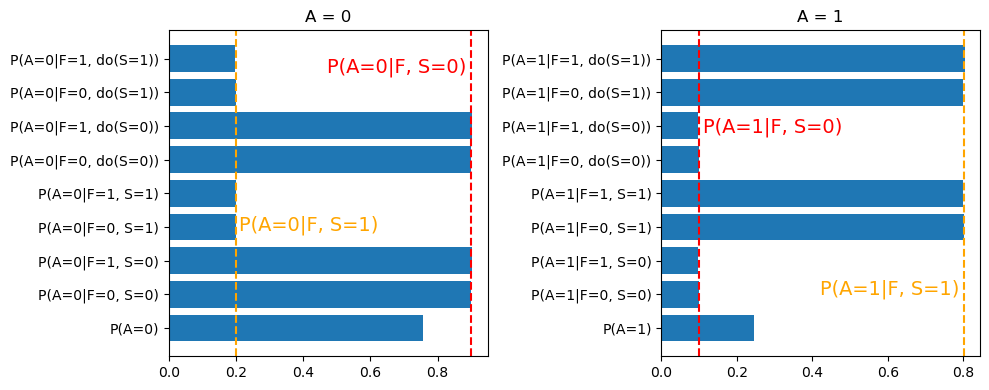

In [42]:
size = 1000000
stats = {}

# observational
fire = np.random.binomial(1, 0.01, size)
smoke = fire * np.random.binomial(1, 0.9, size) + (1-fire) * np.random.binomial(1, 0.2, size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0)'] = (size - alarm.sum()) / size
stats['P(A=1)'] = alarm.sum() / size
stats['P(A=0|F=0, S=0)'] = ((fire == 0) & (alarm == 0) & (smoke == 0)).sum() / ((fire == 0) & (smoke == 0)).sum()
stats['P(A=1|F=0, S=0)'] = ((fire == 0) & (alarm == 1) & (smoke == 0)).sum() / ((fire == 0) & (smoke == 0)).sum()
stats['P(A=0|F=1, S=0)'] = ((fire == 1) & (alarm == 0) & (smoke == 0)).sum() / ((fire == 1) & (smoke == 0)).sum()
stats['P(A=1|F=1, S=0)'] = ((fire == 1) & (alarm == 1) & (smoke == 0)).sum() / ((fire == 1) & (smoke == 0)).sum()
stats['P(A=0|F=0, S=1)'] = ((fire == 0) & (alarm == 0) & (smoke == 1)).sum() / ((fire == 0) & (smoke == 1)).sum()
stats['P(A=1|F=0, S=1)'] = ((fire == 0) & (alarm == 1) & (smoke == 1)).sum() / ((fire == 0) & (smoke == 1)).sum()
stats['P(A=0|F=1, S=1)'] = ((fire == 1) & (alarm == 0) & (smoke == 1)).sum() / ((fire == 1) & (smoke == 1)).sum()
stats['P(A=1|F=1, S=1)'] = ((fire == 1) & (alarm == 1) & (smoke == 1)).sum() / ((fire == 1) & (smoke == 1)).sum()

# interventional do(S=0)
fire = np.random.binomial(1, 0.01, size)
smoke = np.zeros(size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0|F=0, do(S=0))'] = ((fire == 0) & (alarm == 0)).sum() / (fire == 0).sum()
stats['P(A=1|F=0, do(S=0))'] = ((fire == 0) & (alarm == 1)).sum() / (fire == 0).sum()
stats['P(A=0|F=1, do(S=0))'] = ((fire == 1) & (alarm == 0)).sum() / (fire == 1).sum()
stats['P(A=1|F=1, do(S=0))'] = ((fire == 1) & (alarm == 1)).sum() / (fire == 1).sum()

# interventional do(S=1)
fire = np.random.binomial(1, 0.01, size)
smoke = np.ones(size)
alarm = smoke * np.random.binomial(1, 0.8, size) + (1-smoke) * np.random.binomial(1, 0.1, size)
stats['P(A=0|F=0, do(S=1))'] = ((fire == 0) & (alarm == 0)).sum() / (fire == 0).sum()
stats['P(A=1|F=0, do(S=1))'] = ((fire == 0) & (alarm == 1)).sum() / (fire == 0).sum()
stats['P(A=0|F=1, do(S=1))'] = ((fire == 1) & (alarm == 0)).sum() / (fire == 1).sum()
stats['P(A=1|F=1, do(S=1))'] = ((fire == 1) & (alarm == 1)).sum() / (fire == 1).sum()

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,4))
# A = 0
ax0.barh(list(stats.keys())[::2], list(stats.values())[::2])
ax0.axvline(x=stats['P(A=0|F=0, S=0)'], ymin=0, ymax=1, color='r', linestyle='--')
ax0.text(stats['P(A=0|F=0, S=0)']-0.43, 7.6, 'P(A=0|F, S=0)', color='r', size=14)
ax0.axvline(x=stats['P(A=0|F=0, S=1)'], ymin=0, ymax=1, color='orange', linestyle='--')
ax0.text(stats['P(A=0|F=0, S=1)']+0.01, 2.9, 'P(A=0|F, S=1)', color='orange', size=14)
ax0.set_title('A = 0')
# A = 1
ax1.barh(list(stats.keys())[1::2], list(stats.values())[1::2])
ax1.axvline(x=stats['P(A=1|F=0, S=0)'], ymin=0, ymax=1, color='r', linestyle='--')
ax1.text(stats['P(A=1|F=0, S=0)']+0.01, 5.8, 'P(A=1|F, S=0)', color='r', size=14)
ax1.axvline(x=stats['P(A=1|F=0, S=1)'], ymin=0, ymax=1, color='orange', linestyle='--')
ax1.text(stats['P(A=1|F=0, S=1)']-0.38, 1, 'P(A=1|F, S=1)', color='orange', size=14)
ax1.set_title('A = 1')

fig.tight_layout()
plt.show()

As we can see, the distribution of $A$ is practically independent of the value of $F$ and instead only depends on the value of $S$. Furthermore, the observational and post-interventional distributions conditioned on the same value for $S$ yield identical statistics.